The following script was generated by using a customGPT in chatGPT specifically for PINNs to reprodue the results of the Burgers' Equation:

Epoch 0, Loss: 0.6391719579696655
Epoch 100, Loss: 0.19793865084648132
Epoch 200, Loss: 0.15832389891147614
Epoch 300, Loss: 0.14060555398464203
Epoch 400, Loss: 0.13339586555957794
Epoch 500, Loss: 0.12764614820480347
Epoch 600, Loss: 0.12096740305423737
Epoch 700, Loss: 0.11574795842170715
Epoch 800, Loss: 0.11309237033128738
Epoch 900, Loss: 0.10781620442867279
Epoch 1000, Loss: 0.10365202277898788
Epoch 1100, Loss: 0.10032100230455399
Epoch 1200, Loss: 0.09721262007951736
Epoch 1300, Loss: 0.09755996614694595
Epoch 1400, Loss: 0.09165911376476288
Epoch 1500, Loss: 0.0898885577917099
Epoch 1600, Loss: 0.09764407575130463
Epoch 1700, Loss: 0.08700107783079147
Epoch 1800, Loss: 0.0871007889509201
Epoch 1900, Loss: 0.08473403006792068


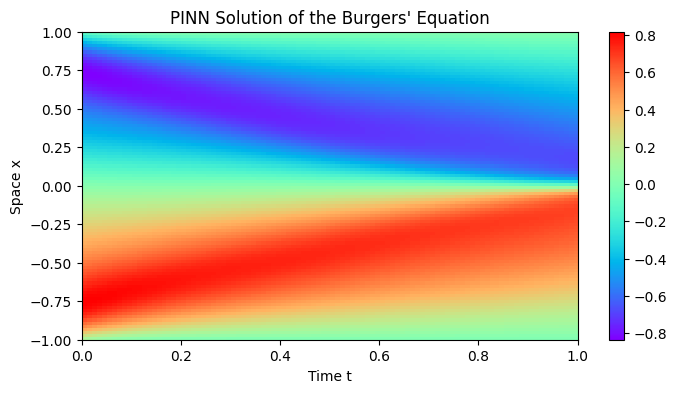

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define the Burgers' equation physics-informed neural network
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )

    def boundary_loss(self, t):
        # Applying boundary conditions at x = -1 and x = 1
        x_left = torch.full_like(t, -1)  # x = -1 for all t
        x_right = torch.full_like(t, 1)  # x = 1 for all t
        u_left = self.forward(torch.cat([x_left, t], dim=1))
        u_right = self.forward(torch.cat([x_right, t], dim=1))
        return torch.mean(u_left**2) + torch.mean(u_right**2)  # Assuming u = 0 at both boundaries

    def forward(self, x):
        return self.net(x)

    def compute_pde(self, x, t):
        """ Compute the PDE residual for Burgers' equation """
        # Properly concatenate x and t for differentiation
        xt = torch.cat([x, t], dim=1)
        u = self.forward(xt)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # Burgers' Equation: u_t + u*u_x - (0.01/pi)*u_xx = 0
        nu = 0.01 #/ np.pi
        pde_residual = u_t + u * u_x - nu * u_xx
        return pde_residual

# Prepare the training data
x = torch.linspace(-1, 1, 100, requires_grad=True).reshape(-1, 1)
t = torch.linspace(0, 1, 100, requires_grad=True).reshape(-1, 1)
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='xy')
X = X.reshape(-1, 1)
T = T.reshape(-1, 1)
XT = torch.cat([X, T], dim=1)

# Initial and boundary conditions (u0 does not need to require gradients)
u0 = -torch.sin(np.pi * X)
u0 = u0.detach()  # Make sure u0 is detached

# Model, optimizer, and training
model = PINN(2, 20, 1)  # Make sure the input size matches the concatenated XT dimensions
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(2000):
    optimizer.zero_grad()
    u_pred = model(XT)
    pde_residual = model.compute_pde(X, T)
    boundary_loss = model.boundary_loss(T.reshape(-1, 1))

    #combine losses
    loss = torch.mean((u_pred - u0) ** 2) + torch.mean(pde_residual ** 2) + boundary_loss
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

'''
# Visualize the solution
with torch.no_grad():
    u_pred = model(XT).reshape(100, 100).cpu().numpy()

plt.imshow(u_pred, interpolation='nearest', cmap='rainbow',
           extent=[0, 1, -1, 1],
           origin='lower', aspect='auto')
plt.colorbar()
plt.title('PINN Solution of the Burgers\' Equation')
plt.xlabel('t')
plt.ylabel('x')
plt.show()
'''

# Visualize the solution
with torch.no_grad():
    u_pred = model(XT).reshape(100, 100).cpu().numpy()

plt.figure(figsize=(8, 4))
# Correct the orientation by setting the extent and axes labels
# The extent parameter defines the [left, right, bottom, top] bounds of the image
plt.imshow(u_pred.T, interpolation='nearest', cmap='rainbow',
           extent=[0, 1, -1, 1],
           origin='lower', aspect='auto')
plt.colorbar()
plt.title('PINN Solution of the Burgers\' Equation')
plt.xlabel('Time t')
plt.ylabel('Space x')
plt.show()


However the script wasn't fully correct, one big issue with the above script is that the initial condition was applied at all times rather than just at t=0 like it should be.

This has been fixed in the script below:

Epoch 0, Loss: 0.6370546221733093
Epoch 100, Loss: 0.14928559958934784
Epoch 200, Loss: 0.12278187274932861
Epoch 300, Loss: 0.10564996302127838
Epoch 400, Loss: 0.09109798818826675
Epoch 500, Loss: 0.07740221917629242
Epoch 600, Loss: 0.06601642072200775
Epoch 700, Loss: 0.05146978422999382
Epoch 800, Loss: 0.037346001714468
Epoch 900, Loss: 0.0357673317193985
Epoch 1000, Loss: 0.02354443445801735
Epoch 1100, Loss: 0.0207888912409544
Epoch 1200, Loss: 0.018633196130394936
Epoch 1300, Loss: 0.017335008829832077
Epoch 1400, Loss: 0.01582329161465168
Epoch 1500, Loss: 0.014713311567902565
Epoch 1600, Loss: 0.013162224553525448
Epoch 1700, Loss: 0.012396292760968208
Epoch 1800, Loss: 0.011157862842082977
Epoch 1900, Loss: 0.010761630721390247


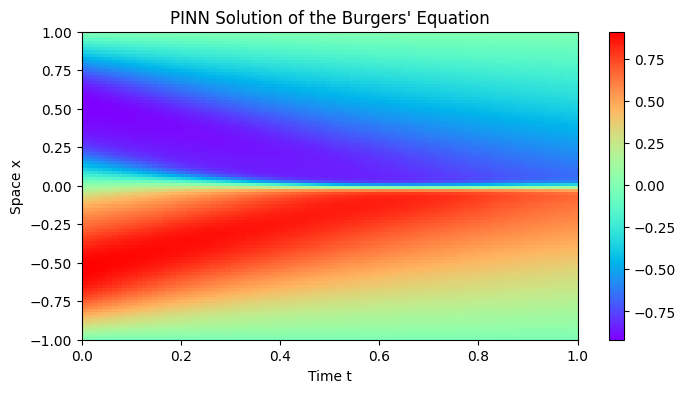

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define the Burgers' equation physics-informed neural network
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )

    def boundary_loss(self, t):
        # Applying boundary conditions at x = -1 and x = 1
        x_left = torch.full_like(t, -1)  # x = -1 for all t
        x_right = torch.full_like(t, 1)  # x = 1 for all t
        u_left = self.forward(torch.cat([x_left, t], dim=1))
        u_right = self.forward(torch.cat([x_right, t], dim=1))
        return torch.mean(u_left**2) + torch.mean(u_right**2)  # Assuming u = 0 at both boundaries

    def forward(self, x):
        return self.net(x)

    def compute_pde(self, x, t):
        """ Compute the PDE residual for Burgers' equation """
        # Properly concatenate x and t for differentiation
        xt = torch.cat([x, t], dim=1)
        u = self.forward(xt)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # Burgers' Equation: u_t + u*u_x - (0.01/pi)*u_xx = 0
        nu = 0.01 #/ np.pi
        pde_residual = u_t + u * u_x - nu * u_xx
        return pde_residual

# Prepare the training data
x = torch.linspace(-1, 1, 100, requires_grad=True).reshape(-1, 1)
t = torch.linspace(0, 1, 100, requires_grad=True).reshape(-1, 1)
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='xy')
X = X.reshape(-1, 1)
T = T.reshape(-1, 1)
XT = torch.cat([X, T], dim=1)

# Initial and boundary conditions (u0 does not need to require gradients)
u0 = -torch.sin(np.pi * X)
u0 = u0.detach()  # Make sure u0 is detached

# Model, optimizer, and training
model = PINN(2, 20, 1)  # Make sure the input size matches the concatenated XT dimensions
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(2000):
    optimizer.zero_grad()

    # Predictions from the model for all time-space points
    u_pred = model(XT)

    # Compute the PDE residual
    pde_residual = model.compute_pde(X, T)

    # Compute the boundary loss
    boundary_loss = model.boundary_loss(T.reshape(-1, 1))

    # Mask for initial condition
    t0_mask = (T == 0).squeeze()

    # Compute loss for initial condition only where t = 0
    initial_condition_loss = torch.mean((u_pred[t0_mask] - u0[t0_mask]) ** 2)

    # Total loss
    loss = initial_condition_loss + torch.mean(pde_residual ** 2) + boundary_loss

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

'''
# Visualize the solution
with torch.no_grad():
    u_pred = model(XT).reshape(100, 100).cpu().numpy()

plt.imshow(u_pred, interpolation='nearest', cmap='rainbow',
           extent=[0, 1, -1, 1],
           origin='lower', aspect='auto')
plt.colorbar()
plt.title('PINN Solution of the Burgers\' Equation')
plt.xlabel('t')
plt.ylabel('x')
plt.show()


#t_range = (t.min().item(), t.max().item())

# Visualize the solution
with torch.no_grad():
    u_pred = model(XT).reshape(100, 100).cpu().numpy()

# Correct the orientation by setting the extent and axes labels
# The extent parameter defines the [left, right, bottom, top] bounds of the image
plt.imshow(u_pred.T, interpolation='nearest', cmap='rainbow', #origin='lower', aspect='auto')
           extent=[t_range.min(), t_range.max(), x_range.min(), x_range.max()],
           origin='lower', aspect='auto')
plt.colorbar()
plt.title('PINN Solution of the Burgers\' Equation')
plt.xlabel('Time t')
plt.ylabel('Space x')
plt.show()
'''

# Visualize the solution
with torch.no_grad():
    u_pred = model(XT).reshape(100, 100).cpu().numpy()

plt.figure(figsize=(8, 4))
# Correct the orientation by setting the extent and axes labels
# The extent parameter defines the [left, right, bottom, top] bounds of the image
plt.imshow(u_pred.T, interpolation='nearest', cmap='rainbow',
           extent=[0, 1, -1, 1],
           origin='lower', aspect='auto')
plt.colorbar()
plt.title('PINN Solution of the Burgers\' Equation')
plt.xlabel('Time t')
plt.ylabel('Space x')
plt.show()


Now a shockwave is visible in the middle after correcting the I.C.

In [ ]:
# Save the numpy array as a .npy file
np.save('/content/pinn_solution.npy', u_pred)

# Code to download the file directly in Google Colab
from google.colab import files
files.download('/content/pinn_solution.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Numerical Solution

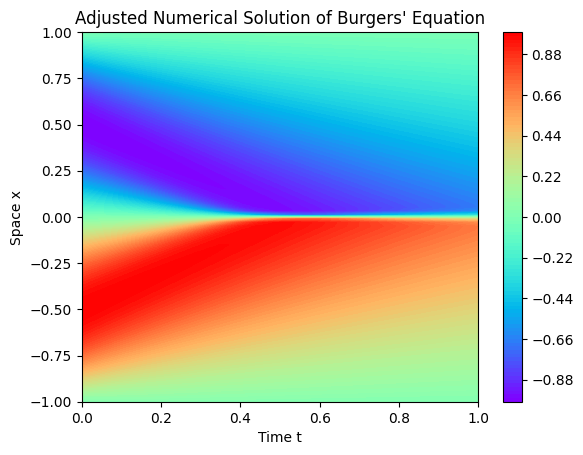

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the spatial domain and parameters
x_range = np.linspace(-1, 1, 100)
dx = x_range[1] - x_range[0]
dt = 0.01  # Adjust time step size to match PINN resolution of 100 time steps
t_end = 1.0
t_range = np.arange(0, t_end + dt, dt)
nu = 0.01  # viscosity for viscous simulation

# Initial condition
u0 = -np.sin(np.pi * x_range)

# Function to solve the heat equation for the viscous Burgers' equation using forward time central space (FTCS) scheme
def viscous_burgers_ftcs(u, dx, dt, nu):
    u_pad = np.pad(u, (1, 1), 'constant', constant_values=(0, 0))  # Use zero padding for boundaries
    du_dx = (u_pad[2:] - u_pad[:-2]) / (2 * dx)
    d2u_dx2 = (u_pad[2:] - 2 * u_pad[1:-1] + u_pad[:-2]) / dx**2
    u_next = u + dt * (-u * du_dx + nu * d2u_dx2)
    return u_next

# Simulate viscous Burgers' equation using time stepping
u_viscous = np.zeros((len(t_range), len(x_range)))
u_viscous[0, :] = u0

for n in range(1, len(t_range)):
    u_viscous[n, :] = viscous_burgers_ftcs(u_viscous[n-1, :], dx, dt, nu)

# Save the adjusted numerical solution
np.save('/content/adjusted_numerical_solution.npy', u_viscous)

# Optionally, plot the viscous solution
#plt.figure(figsize=(8, 4))
plt.contourf(t_range, x_range, u_viscous.T, cmap='rainbow', levels=100)
plt.title('Adjusted Numerical Solution of Burgers\' Equation')
plt.xlabel('Time t')
plt.ylabel('Space x')
plt.colorbar()
plt.show()


The following numerical solution was also generated by chatGPT by using a customGPT designed for solving PDEs. This plot is very similar to what's in the paper *Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations* by Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis.

Attempting to compare MSE between the PINNs solution and the numerical solution (ran out of time to complete this so it's currently giving errors)

In [ ]:
# Assuming u_viscous is your solution array from the numerical method
np.save('numerical_solution.npy', u_viscous)

In [ ]:
# Save the numpy array as a .npy file
np.save('/content/numerical_solution.npy', u_viscous)

# Code to download the file directly in Google Colab
from google.colab import files
files.download('/content/numerical_solution.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

# Assuming the files are in the root directory of your Colab environment
pinn_solution = np.load('/content/pinn_solution.npy')
numerical_solution = np.load('/content/numerical_solution.npy')

# Calculate MSE
mse = np.mean((pinn_solution - numerical_solution) ** 2)
print(f"The Mean Squared Error (MSE) between the PINN and numerical solutions is: {mse}")


ValueError: operands could not be broadcast together with shapes (100,100) (1001,100) 